# Part III: Random Forest Prediction Based Trading Strategy 

As shown in the previous section, we first mined the order book data and created the entire order book data structure to simulate the order book process.
After correctly handling all the bids and asks, we are able to summarize the total trades within each seconds/minutes to arrive at a cleaner dataset.
In this phase, we collect all quantities traded within each minute to arrive at a Volume series. We also calculated the per second weighted average trading price and combined them into
per minute Open, Close, High, and Low time series.

This allows us to treat the polished data as a general stock dataset and perform return or trend predictions based on meaningful technical indicators for both the price and the volume traded.


The code below demonstrates the process of calculating a variety of indicators:

In [303]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [304]:
#Reads in the original raw data
df=pd.read_csv('btc_usd.csv',header=0,skiprows=0,index_col=0)

In [143]:
Datetime=df['datetime']
ID = df['id']
Type = np.array(df['type'])
V = df['quantity']
P = df['price']
VT = df['total']

Use previously calculated data matrix containing all needed series.

In [343]:
X=np.load('prices.npy')
O = X[:,0]
C = X[:,1]
H = X[:,2]
L = X[:,3]
MV = X[:,4]

### MACD(10,30,9)  (Moving Average Convergence/Divergence)

In [344]:
X_original=C
a=1-2.0/11.0
b=1-2.0/31.0
ema_a = X_original[0]
ema_b = X_original[0]
EMA_a = [ema_a]
EMA_b= [ema_b]
for i in range(1,len(X_original)):
    close = X_original[i]  
    ema_a = EMA_a[-1]*a+close*(1-a)
    ema_b = EMA_b[-1]*b+close*(1-b)
    EMA_a.append(ema_a)
    EMA_b.append(ema_b)
DIFF = np.array(EMA_a)-np.array(EMA_b)
DEA=[DIFF[0]]
c = 1-1.0/5.0
for i in range(1,len(DIFF)):
    close =DIFF[i]  
    dea = DEA[-1]*c+close*(1-c)
    DEA.append(dea)
MACD = 2*(DIFF-DEA)

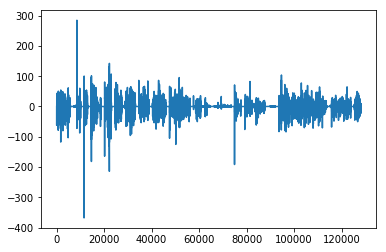

In [345]:
plt.plot(MACD)

### RSI (Relative Strength Indicator)

Using history of 15 minutes

In [501]:
RSI=[]
hist=15
Ret = (C[1:]-C[:-1])/C[:-1]
for i in range(hist,len(C)):
    
    p=Ret[i-hist:i]
    pu=p[p>0]
    pd=p[p<0]
    
    if len(pd)==0 or np.mean(pd)==0:
        RSI.append(100)
    elif len(pu)==0 or np.mean(pu)==0:
        RSI.append(0)
    else:
        su=abs(np.mean(pu))
        sd=abs(np.mean(pd))
        rs=(su)/(sd)
       
        rsi=100-100.0/(1+rs)
        
        RSI.append(rsi)
        #print rsi
RSI=np.array(RSI)

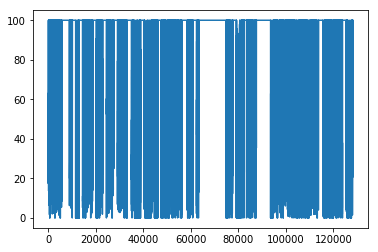

In [502]:
plt.plot(RSI)

### OBV (On Balance Volume) 

In [503]:
OBV=[0]
for i in range(1,len(C)):
    if C[i]>C[i-1]:
        OBV.append(OBV[-1]+MV[i-1])
   
    else:
        OBV.append(OBV[-1]-MV[i])
OBV=np.array(OBV)


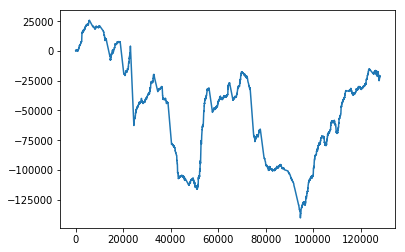

In [504]:
plt.plot(OBV)

In [505]:
len(RSI),len(OBV),len(MACD)

(128159, 128174, 128174)

### VRSI (Volume Relative Strength Index)

Using history of 15 minutes

In [506]:
VRSI=[]
hist=15
VRet = (MV[1:]-MV[:-1])/MV[:-1]
for i in range(hist,len(C)):
    
    p=VRet[i-hist:i]
    pu=p[p>0]
    pd=p[p<0]
    
    if len(pd)==0 or np.mean(pd)==0:
        VRSI.append(100)
    elif len(pu)==0 or np.mean(pu)==0:
        VRSI.append(0)
    else:
        su=abs(np.mean(pu))
        sd=abs(np.mean(pd))
        rs=(su)/(sd)
       
        rsi=100-100.0/(1+rs)
        
        VRSI.append(rsi)
        #print rsi
VRSI=np.array(VRSI)

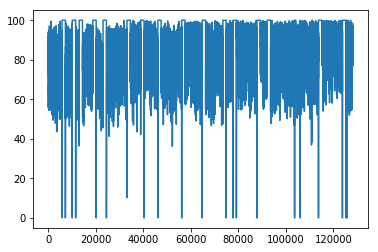

In [507]:
plt.plot(VRSI)

### Smart Money

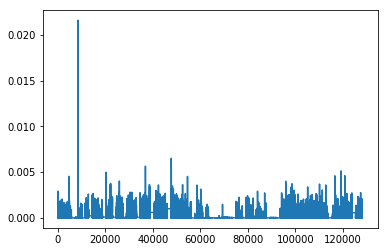

In [371]:
SM =np.load('smart_money.npy')
plt.plot(SM)

In [372]:
len(SM)

128174

### Force Index 

128159

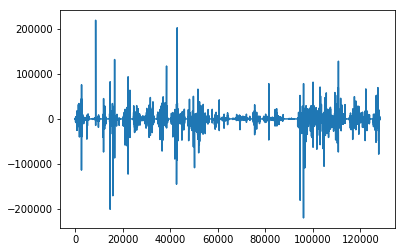

In [508]:
Force = (C[hist:]-C[:-hist])*(MV[hist:]-MV[:-hist])
plt.plot(Force)
len(Force)

### PVI (Positive Volume Index) 

128174

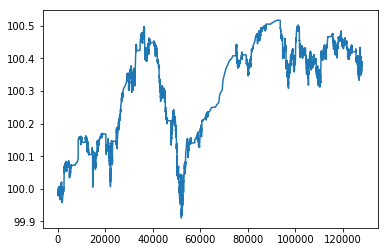

In [509]:
PVI=np.load('pvi.npy')
plt.plot(PVI)
len(PVI)

### SO (Stochastic Indicator) 

Using history of 15 minutes

In [510]:
SO=[]
for i in range(hist,len(C)):
    
    c=C[i]
    h=max(H[i-hist+1:i+1])
    l=min(L[i-hist+1:i+1])
    if h==l:
        SO.append(0)
    else:
        k=100*(c-l)/(h-l)
        SO.append(k)
SO=np.array(SO)

128159

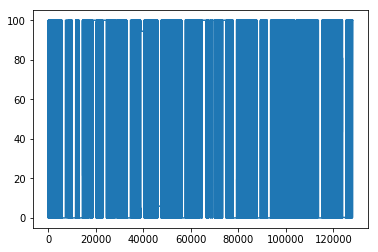

In [511]:
plt.plot(SO)
len(SO) 

### High Price Moving Average Band 

128159

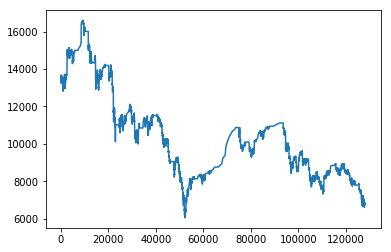

In [512]:
HB = np.load('high_band.npy')
plt.plot(HB)
len(HB)

### Low Price Moving Average Band 

128159

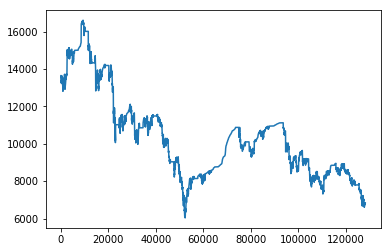

In [513]:
LB = np.load('low_band.npy')
plt.plot(LB)
len(LB)

In [ ]:
#Some functions for calculating technical indicators
import math

def smart_money(prices):
    sm = []
    n = len(prices)
    for i in range(n):
        sm.append(abs(math.log(prices.close[i]) - math.log(prices.open[i])) / math.sqrt(prices.vol[i]))
    return sm

def vrsi(prices, N):
    i = N
    dp_incr = []
    dp_decr = []
    vrsi = []
    for j in range(1, N):
        if prices.vol[j] > prices.vol[j - 1]:
            dp_incr.append(prices.vol[j] - prices.vol[j - 1])
            dp_decr.append(0)
        else:
            dp_decr.append(prices.vol[j - 1] - prices.vol[j])
            dp_incr.append(0)
    vrsi.append(100 - (100 * sum(dp_decr) / (sum(dp_decr) + sum(dp_incr))))
    
    while i < len(prices):
        dp_incr.remove(dp_incr[0])
        dp_decr.remove(dp_decr[0])
        if prices.vol[i] > prices.vol[i - 1]:
            dp_incr.append(prices.vol[i] - prices.vol[i - 1])
            dp_decr.append(0)
        else:
            dp_decr.append(prices.vol[i - 1] - prices.vol[i])
            dp_incr.append(0)
        vrsi.append(100 - (100 * sum(dp_decr) / (sum(dp_decr) + sum(dp_incr))))
        i + 1
    
    return vrsi

def pvi(prices, N = 72):
# adding PVIyesterday (Ct - Cy) / Cy to yesterday's PVI if today's volume is higher than yesterday's, adding zero otherwise
    pvi = [100]
    for i in range(1, len(prices)):
        if prices.vol[i] > prices.vol[i - 1]:
            pv = prices.close[i] / prices.close[i - 1] - 1
        else:
            pv = 0
        pvi.append(pvi[-1] + pv)
    return pvi

def nvi(prices):
# adding NVIyesterday (Ct - Cy) / Cy to yesterday's NVI if today's volume is lower than yesterday's, adding zero otherwise
    nvi = [100]
    for i in range(1, len(prices)):
        if prices.vol[i] < prices.vol[i - 1]:
            nv = prices.close[i] / prices.close[i - 1] - 1
        else:
            nv = 0
        nvi.append(nvi[-1] + nv)
    return nvi

def vr(prices):
    t1 = max(abs(prices.high[1] - prices.low[1]), abs(prices.high[1] - prices.close[0]), abs(prices.low[1] - prices.close[0]))
    vr = []
    for t in range(2, len(prices)):
        t0 = t1
        t1 = max(abs(prices.high[t] - prices.low[t]), abs(prices.high[t] - prices.close[t - 1]), abs(prices.low[t] - prices.close[t - 1]))
        if t0 == 0:
            vr.append()
        else:
            vr.append(t1 / t0)
    return vr

def htl(prices):
    htl = []
    for i in range(len(prices)):
        htl.append(prices.high[i] / prices.low[i])
    return htl

def high_band(prices, N = 15):
    high_band = []
    for i in range(15, len(prices)):
        high_band.append(sum(prices.high[i - 15: i]) / len(prices.high[i - 15: i]))
    return high_band

def low_band(prices, N = 15):
    low_band = []
    for i in range(15, len(prices)):
        low_band.append(sum(prices.low[i - 15: i]) / len(prices.low[i - 15: i]))
    return low_band

## Target Construction 

We consider the problem of clssifying if the stock return exceeds a certain magnitude in a certain amount of time.
After calibrating the hyperparameters, we choose a forecast range of 60 minutes and a target threshold of 0.1% such that
if the stock rise more than 0.1% in 60 minutes the label is 1, if the stock drops more than 0.1% the label is -1, and otherwise 0.
Since we can invest in both long and short positions, this classifcatoin result can help us determine a trading strategy hopefully.

In [517]:
Y = []
ts=60
th=0.001
OBV_=OBV[hist:-ts]
RSI_=RSI[:-ts]
SO_=SO[:-ts]
Skew_=skew[hist:-ts]
Force_=Force[:-ts]
VRSI_ = VRSI[:-ts]
MACD_=MACD[hist:-ts]
SM_=SM[hist:-ts]
PVI_=PVI[hist:-ts]
HTL_=HTL[hist:-ts]
HB_=HB[:-ts]
LB_=LB[:-ts]
Z=[]
for i in range(hist,len(C)-ts):
    future=X_original[i+ts]/X_original[i]-1
    Z.append(future)
    y=int(future>th)-int(future<-th)
    Y.append(y)

The following plot shows the true labels for each point in the minute price dataset.

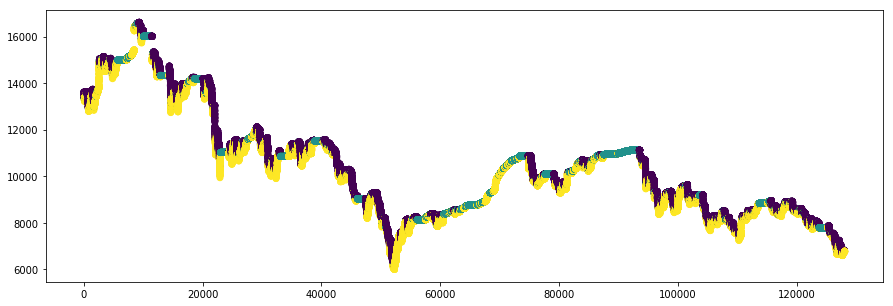

In [515]:
plt.figure(figsize=(15,5))

plt.scatter(range(len(X_original[hist:-ts])),X_original[hist:-ts],c=Y)

Train-test split:

In [ ]:
XX = [[HB_[i],LB_[i],PVI_[i],VRSI_[i],RSI_[i],MACD_[i],OBV_[i],Y[i],Z[i]] for i in range(len(Y)-ts)]

XXX =[[HB_[i],LB_[i],PVI_[i],VRSI_[i],RSI_[i],MACD_[i],OBV_[i]] for i in range(len(Y))]
XX=np.array(XX)

XXX=np.array(XXX)

### We decide to use the random forest classifier for this problem, which consists of many decision trees to determine the label for a feature vector. Our chosen features, after calibration and optimization, include High Band, Low Band, PVI, VRSI, RSI, MACD, and OBV. 

The figure below demonstrates a typical random forest classifier: (https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)

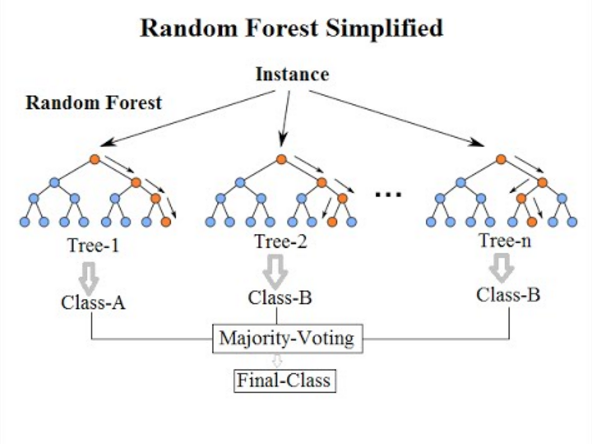

In [2]:
from IPython.display import display, Image
display(Image(filename='RF.png'))

In [532]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestClassifier(max_depth=15,n_estimators=50, random_state=0)
clf.fit(X_train,y_train)
regr = RandomForestRegressor(max_depth=15, random_state=0,n_estimators=50)
regr.fit(X_train,z_train)
y_pred=clf.predict(XXX)
z_pred=regr.predict(XXX)

In [533]:
print(regr.feature_importances_)

[0.15624799 0.14320941 0.22756263 0.03646828 0.03778201 0.03735926
 0.36137043]


The training and tesitng accuracies are shown below, both indicates high accuracy and a small discrepancy in between.

In [534]:
clf.score(X_train,y_train),clf.score(X_test,y_test)

(0.9385125, 0.9065587217803773)

The predicted labels are shown below:

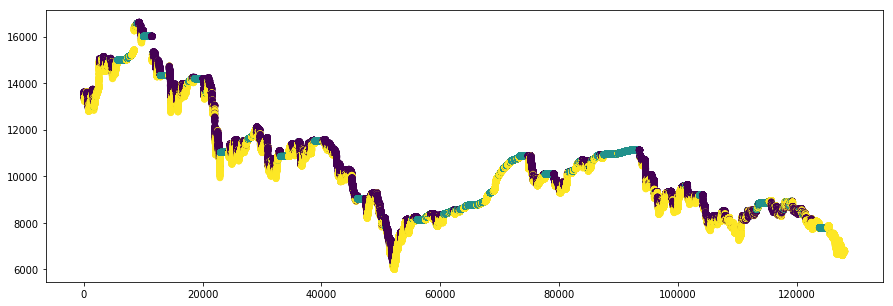

In [536]:
plt.figure(figsize=(15,5))
plt.scatter(range(len(y_pred)),X_original[hist:-ts],c=y_pred)

## Trading Strategy 

To compare how our prediction behaves in real trading scenarios against the market, we design a simple trading strategy that takes each minute's label prediction, and
buy/hold long if the signal is 1, buy/hold short if the signal is -1, and otherwise sell the position. Notice that a signal transition of 1 to -1 or -1 to 1 consists
of selling the original position and opening a new position simultaneously.
The trades are assumed to occur at the open price of the new minute period with an associated trading fee of 0.02%.

In [537]:
Trade = np.array(O[hist+1:])
#Trade_date = np.array(df['Date'])[hist+1:][test_start:test_start+test_N+1]
#plt.plot(Trade_date,Trade)
#Close = X_original[3237:]
def one_day_trade_result(signal,last_sig,status,p,today_open,ref,trades,l):
   
    if signal==last_sig:
        action='hold'
        
    elif last_sig==1 and signal==-1:
        if status=='long':
            p = p*today_open/ref
            l.append(p)
            action='end long and short'
        else:
            action='enter short'
        status='short'
        ref = today_open
        trades+=1
    elif last_sig==-1 and signal==1:
        if status=='short':
            p = p*(2-today_open/ref)
            l.append(p)
            action='end short and long'
        else:
            action='enter long'
        status='long'
        ref = today_open
        trades+=1
    elif signal==0:
        if status=='short':
            p = p*(2-today_open/ref)
        elif status=='long':
            p=p*today_open/ref
        else:
            pass
        l.append(p)
        action='end position'
        status='none'
        ref=today_open
    elif last_sig==0:
        if signal==1:
            action ='enter long'
            status='long'
            ref = today_open
            trades+=1
        else:
            action ='enter short'
            status='short'
            ref=today_open
            trades+=1
    return [p,action,status,trades,l,ref]

The cumulative trading results are shown below for the entire data period:

In [538]:
    Signal =y_pred
    all_record=[]
    Trade = np.array(O[hist+1:-ts])
    N = len(Trade)-1
    trade_testdate=Min[hist:-ts]
    p=1
    status='none'
    ls = 0
    num=0
    days=0
    l=[p]
    ref = Trade[0]
    for i in range(N):
        s = Signal[i]
        #s = max(s,0)
        (p,a,status,num,l,ref) = one_day_trade_result(s,ls,status,p,Trade[i],ref,num,l)
        #print ls,s,a,p,status
            
        if a!='hold':
            if 'end' in a:
                all_record.append(str(trade_testdate[i])+' '+a+' Return: '+str(round(100*(l[-1]-l[-2])/l[-2],3))+'%')
            else:
                all_record.append(str(trade_testdate[i])+' '+a)
        if i==N-1:
                if status=='short':
                    p = p*(2-Trade[N]/ref)
                    status='none'
                    a='end year'
                    l.append(p)
                    all_record.append(str(trade_testdate[N])+' '+a+' Return: '+str(round(100*(l[-1]-l[-2])/l[-2],3))+'%')
                elif status=='long':
                    p=p*Trade[N]/ref
                    status='none'
                    a='end year'
                    l.append(p)
                    all_record.append(str(trade_testdate[N])+' '+a+' Return: '+str(round(100*(l[-1]-l[-2])/l[-2],3))+'%')
                else:
                    pass
          
        ls = s
        if status=='none':
            days+=1
    r=p-1
    market = Trade[-1]/Trade[0]-1
    adv = r-market
    l=np.array(l)
    wins = (l[1:]-l[:-1])>0
    l = np.array(l)
    #print l
    fee=0.0002
    rets = (l[1:]-l[:-1])/l[:-1]
    std = np.std(rets)
    
    total = sum((l[1:]-l[:-1])/l[:-1])-fee*num
    sharpe=total/(num*std)
    print('Sharpe:'+str(sharpe))
    adv=total-market
    try:
        print(str(trade_testdate[0])[:10]+' TO '+str(trade_testdate[-1])[:10]+'  Ret:'+str(round(100*total,3))+'%'+'  Adv:'+str(round(100*adv,3))+'%'+'  WinRatio:'+str(round(100*sum(wins)/(len(l)-1.0),3))+'%')
    except:
        pass
    print('Trades: '+str(num)+' Minutes in Market: '+str(N-days))
    print('')

Sharpe:0.2469953963329434
2018-01-01 TO 2018-03-30  Ret:821.92%  Adv:872.183%  WinRatio:56.406%
Trades: 3567 Minutes in Market: 88913



In [540]:
all_record

['2018-01-01 00:15:01 enter short',
 '2018-01-01 00:16:01 end short and long Return: 0.015%',
 '2018-01-01 00:33:01 end long and short Return: -0.191%',
 '2018-01-01 00:38:01 end short and long Return: 0.177%',
 '2018-01-01 00:39:01 end long and short Return: 0.037%',
 '2018-01-01 01:57:01 end short and long Return: 2.127%',
 '2018-01-01 02:05:01 end long and short Return: 0.762%',
 '2018-01-01 02:18:01 end short and long Return: 0.352%',
 '2018-01-01 02:49:01 end long and short Return: 0.113%',
 '2018-01-01 02:50:01 end short and long Return: -0.008%',
 '2018-01-01 03:13:01 end long and short Return: 0.188%',
 '2018-01-01 03:20:01 end short and long Return: -0.142%',
 '2018-01-01 07:43:01 end long and short Return: 1.526%',
 '2018-01-01 08:28:01 end short and long Return: -0.442%',
 '2018-01-01 08:32:01 end long and short Return: -0.154%',
 '2018-01-01 08:33:01 end position Return: 0.808%',
 '2018-01-01 08:34:01 enter long',
 '2018-01-01 09:17:01 end long and short Return: 0.2%',
 '20